In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVR

%matplotlib inline

In [2]:
df = pd.read_csv('AMZN_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [3]:
df.index = pd.to_datetime(df.index)

In [19]:
df2 = df.drop(['sma252','sma50','ema22zone','ema252zone', 'ema50', 'BBU_5_2.0', 'ema7zone', 'sma22', 'ema50zone', 'BBL_5_2.0', 'BBM_5_2.0', 'ema22', 'sma7','ema252', 'dspic'],axis = 1)

In [20]:
corrs = df2.corr().stack().reset_index()
corrs.columns = ['1','2','R2']
temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
correlations = temp[temp.index % 2 == 0]

In [21]:
correlations

,1,2,R2
0,m2,ccpi,0.971442
2,low,m2,0.904069
4,ema7,m2,0.903927
6,close,m2,0.903861
8,m2,close,0.903861
10,open,m2,0.903710
12,high,m2,0.903488
14,ir,ffer,0.803985


In [22]:
df2 = df2[df2.index > '2010-1-1']

In [23]:
X = df2.shift(1).dropna()
y = df2['adjustedclose'].iloc[1:]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, test_size = .2)

In [25]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [26]:
X_train_scaled

,low,open,volume,high,close,adjustedclose,rsi,BBB_5_2.0,BBP_5_2.0,ema7,...,RSI_overbought_cross,RSI_oversold_cross,RSI_overbought,RSI_oversold,momentum,psr,m2,ccpi,ir,ffer
0,-0.513044,-0.470734,6.569028,-0.474891,-0.518822,-0.518822,2.344303,2.147055,1.588133,-0.554139,...,-0.158450,-0.076456,2.971978,-0.093776,0.941558,-0.269021,-0.290324,-0.229093,0.186538,-0.583111
1,-0.787674,-0.786468,-0.841874,-0.788599,-0.788975,-0.788975,-0.543093,-0.425710,-0.835754,-0.785501,...,-0.158450,-0.076456,-0.336476,-0.093776,-0.230154,0.097891,-0.827390,-0.913245,-0.648064,-0.544729
2,-0.733516,-0.730695,-0.165466,-0.730978,-0.733349,-0.733349,-1.270621,0.047518,0.773162,-0.731333,...,-0.158450,-0.076456,-0.336476,-0.093776,-0.339154,-0.321437,-0.515999,-0.527628,0.524939,-0.642228
3,-0.153082,-0.157429,-0.757403,-0.165341,-0.161186,-0.161186,0.388189,-1.233448,-1.281094,-0.158289,...,-0.158450,-0.076456,-0.336476,-0.093776,-0.125515,-0.295229,0.183296,0.285874,0.147320,0.464047
4,2.102230,2.077879,-0.821611,2.054960,2.074768,2.074768,-0.857408,-0.940601,-0.542727,2.093875,...,-0.158450,-0.076456,-0.336476,-0.093776,-0.645099,0.307555,2.248271,1.879798,-0.975782,-0.654668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,-0.314870,-0.315533,-0.559928,-0.322569,-0.318111,-0.318111,0.637856,-0.319474,0.716583,-0.326115,...,-0.158450,-0.076456,-0.336476,-0.093776,0.194882,-0.400061,-0.042221,0.082958,-0.997559,-0.225764
2405,-0.743460,-0.746299,-0.265275,-0.740511,-0.738339,-0.738339,-1.020803,0.292592,1.286560,-0.741274,...,-0.158450,-0.076456,-0.336476,-0.093776,-0.050399,-0.321437,-0.515999,-0.527628,0.524939,-0.642228
2406,-0.713148,-0.715750,-0.474291,-0.711902,-0.709727,-0.709727,0.381583,-0.543666,1.493638,-0.713620,...,-0.158450,-0.076456,-0.336476,-0.093776,-0.044295,-0.295229,-0.478002,-0.488147,0.500732,-0.636933
2407,-0.662752,-0.665988,-0.473953,-0.659540,-0.658394,-0.658394,1.489008,-0.729321,1.165245,-0.662649,...,6.311142,-0.076456,2.971978,-0.093776,0.025465,-0.059357,-0.348855,-0.370950,-0.317498,-0.609928


In [27]:
svr = LinearSVR(random_state = 42, max_iter = 10e5)

In [28]:
svrmodel = svr.fit(X_train_scaled, y_train)

In [29]:
train_score = svr.score(X_train_scaled, y_train)
y_hat_train = svr.predict(X_train_scaled)
train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
train_cv_score = cross_val_score(svrmodel, X_train_scaled, y_train, n_jobs = -1).mean()

print(f'Train Score : {train_score}')
print(f'Train RMSE : {train_rmse}')
print(f'Mean Train Cross-Validation Score: {train_cv_score}')

Train Score : 0.9989344979091094
Train RMSE : 33.683658393502945
Mean Train Cross-Validation Score: 0.9976452721240866


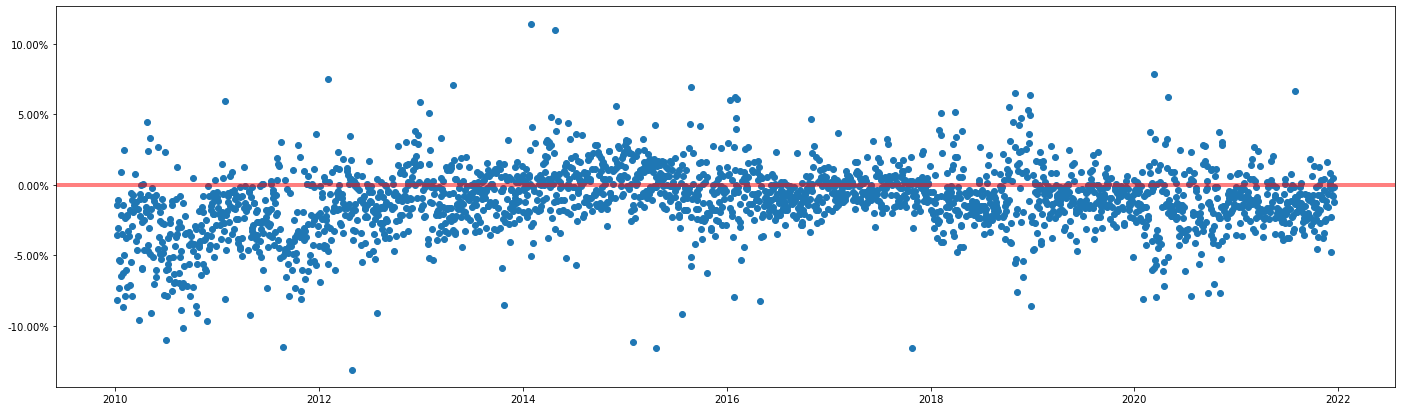

In [30]:
fig, ax = plt.subplots(figsize = (24,7))
plot_x = y_train.index
plot_y = (y_hat_train - y_train)/y_train
plt.scatter(plot_x,plot_y)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0);

In [31]:
test_score = svr.score(X_test_scaled, y_test)
y_hat_test = svr.predict(X_test_scaled)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(f'Test Score : {test_score}')
print(f'Test RMSE : {test_rmse}')

Test Score : 0.9987046162316292
Test RMSE : 37.897327629028204


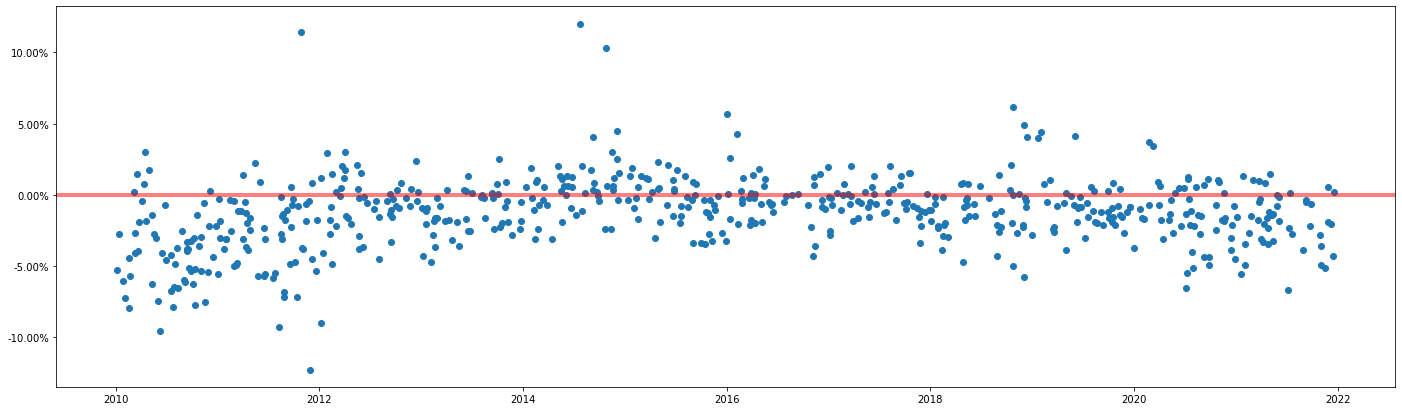

In [32]:
fig, ax = plt.subplots(figsize = (24,7))
ax.scatter(y_test.index, (y_hat_test - y_test)/y_test)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0);

In [18]:
preds = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index)], axis = 1)